# 転移学習とCAM

こんにちは。神大の味岡です。一年くらい前 (編注: 原記事が執筆された2019年6月頃のこと) にdeep learningを使用した画像分類をしていたので、それについて書きたいと思います。サンプルとして、Kaggleのdog vs catを用いました。
とてもありがちな内容で恐縮ですがよろしくお願いします。

## 転移学習とは 

deep learningには、大量のデータが必要とよく言われますよね。しかし、いつも十分なサンプルデータが得られるとは限りません。そこで、既に大量のデータで学習して得られたモデルを活用してそこに修正を加えてオリジナルのモデルを作るという技術が作られました。いうなれば既存のモデルのチューニングするようなイメージです。層の最後のみを調整するのをtransfer learning、層の全体を調整するのをfine tuningというそうです。
CNNによる画像分類では、転移学習はよく使用されます。なぜなら画像分類で用いるCNNでは、入力に近い層は単純なパターンを認識するもので、これはどんな画像にも適用しやすいからです。
今回は既存のモデルとしては有名なVGG16を使用しました。これに全結合層を追加して、最終層に犬と猫の２クラス分類を出力させました。

### 環境設定

環境は以下です。

Ubuntu 16.04

CUDA 9.0

Anaconda

Python 3.5

tensorflow-gpu==1.10.0

Keras==2.2.2

画像系のDeep Learningは処理が重いので、GPUを活用するのがおすすめです。

### 使用したデータ
Kaggleのdog vs catです。https://www.kaggle.com/c/dogs-vs-cats/data

### コード
以下は転移学習のコードです。パラメーター設定の部分を変えれば、様々な画像の分類に使えるようにしました。パラメータの[#training dataの場所]と[#validation dataの場所]には、分類された画像を入れたフォルダが入ります。今回は「dog」フォルダと「cat」フォルダにそれぞれ犬、猫の画像を入れました。trainingにはそれぞれ1000枚ずつ、validationにはそれぞれ400枚ずつ入れました。

追記：VGG16の入力形式に合わせて、ImageGeneratorの部分をrescale=1.0/255ではなく、preprocessing_function=preprocess_input_vggにする例もあります。

In [10]:
# パッケージのインポート
import warnings
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras import optimizers

# warningを非表示にする
warnings.filterwarnings('ignore') 

# パラメーター設定
train_dir = 'DogCat/train' #training dataの場所
valid_dir = 'DogCat/valid' #validation dataの場所
n_categories = 2 # 分類クラスの数
training_start_layer = 18 # 解凍する層の場所がVGG16最後の一層だけなら18
height = 256 # 画像のサイズ(縦)
width = 256 # 画像のサイズ(横) 
EPOCH = 30 # エポック数

# モデル作成
base_model=VGG16(weights='imagenet',include_top=False,
                 input_tensor=Input(shape=(height,width,3)))
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_categories, activation='softmax'))
model=Model(inputs=base_model.input,outputs=top_model(base_model.output))

# 層の凍結
for layer in base_model.layers[:training_start_layer]:
    layer.trainable=False

# モデルの表示
model.summary()

# 学習設定
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

# 画像データ設定
image_data_generator = image.ImageDataGenerator(rescale=1.0/255)
train_data =image_data_generator.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)
image_data_generator = image.ImageDataGenerator(rescale=1.0/255)
validation_data = image_data_generator.flow_from_directory(
    valid_dir,
    target_size=(height, width),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# 学習の実行
history = model.fit_generator(
      train_data,
      steps_per_epoch=100,
      epochs=EPOCH,
      validation_data=validation_data,
      validation_steps=50,
      verbose=2)

# パラメータ保存
file_name = 'vgg16_transferlearning_weights'
model.save(file_name+'.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

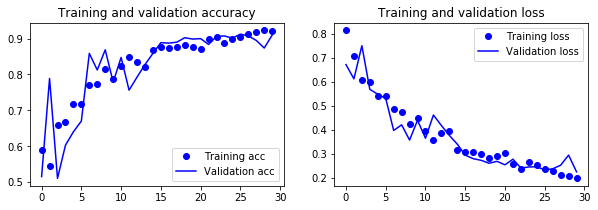

In [12]:
# 図の作成
plt.figure(figsize=(10,3))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

エポックが進むごとにaccuracyは上昇してlossが下がっていったので、学習できたと思います。

## CAM (Class Activation Map)

せっかくなので、Grad-CAMでの判断根拠の可視化もやってみます。

deep learningはブラックボックスと言われていますが、CNNではCAMで判断根拠の可視化を行いことができます。中でもGrad-CAMは有名です。

コードはhttps://qiita.com/haru1977/items/45269d790a0ad62604b3
のものを使わせて頂きました。

実行にはopencv-pythonもインストールする必要があります。

In [27]:
import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1) #set learning phase

def Grad_Cam(input_model, x, layer_name):
    '''
    Args:
       input_model: モデルオブジェクト
       x: 画像(array)
       layer_name: 畳み込み層の名前

    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)

    '''
    # 前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0
    # 予測クラスの算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]
    #  勾配を取得
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]
    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (256, 256), cv2.INTER_LINEAR) # 画像サイズは200で処理したので
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成
    return jetcam

Grad-CAMではモデルの層を指定して行うようです。
いくつかの猫の画像で判断根拠の可視化をやってみます。

猫の確率は0.99872714


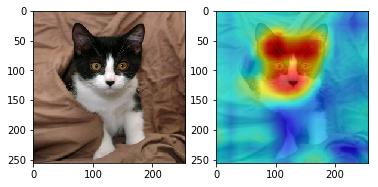

In [54]:
input_dir = 'DogCat/valid/cats'
layer = 'block5_conv3'

i = 'cat.1002.jpg' #画像ファイルの名前
x = img_to_array(load_img(input_dir + '/' + i, target_size=(256,256)))
prob = model.predict(np.expand_dims(x, axis=0) / 255.0)
print('猫の確率は'+ str(prob[0][0]))
plt.subplot(1,2,1)
plt.imshow(x / 255.0)
plt.subplot(1,2,1)
cam = Grad_Cam(model, x, layer)
plt.subplot(1,2,2)
plt.imshow(cam / cam.max())
plt.show()

猫の確率は0.9936093


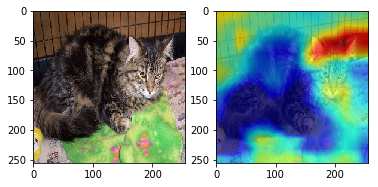

In [49]:
i = 'cat.1005.jpg'
x = img_to_array(load_img(input_dir + '/' + i, target_size=(256,256)))
prob = model.predict(np.expand_dims(x, axis=0) / 255.0)
print('猫の確率は'+ str(prob[0][0]))
plt.subplot(1,2,1)
plt.imshow(x / 255.0)
plt.subplot(1,2,1)
cam = Grad_Cam(model, x, layer)
plt.subplot(1,2,2)
plt.imshow(cam / cam.max())
plt.show()

猫の確率は0.95646036


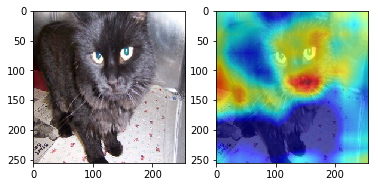

In [53]:
i = 'cat.1010.jpg'
x = img_to_array(load_img(input_dir + '/' + i, target_size=(256,256)))
prob = model.predict(np.expand_dims(x, axis=0) / 255.0)
print('猫の確率は'+ str(prob[0][0]))
plt.subplot(1,2,1)
plt.imshow(x / 255.0)
plt.subplot(1,2,1)
cam = Grad_Cam(model, x, layer)
plt.subplot(1,2,2)
plt.imshow(cam / cam.max())
plt.show()

猫の顔や耳に反応していますね。
ただし、他の画像では変な場所に反応している画像もありました。

## 感想

deep learningライブラリの中でもKerasは初心者でも使いやすいライブラリだなと思いました。ImageDataGeneratorが便利ですね。

CAMに関してはExplainable AI（説明可能なAI）に繋がる素晴らしい技術だと思いました。医療AIにも応用されていくのかなと思います。

## 参考文献

VGG16の転移学習

http://aidiary.hatenablog.com/entry/20170108/1483876657

https://qiita.com/yampy/items/6f1f48fee16db7888f07

CAMについて

https://qiita.com/bukei_student/items/698383a7118f95c12cce

Grad-CAMのコード

https://qiita.com/haru1977/items/45269d790a0ad62604b3